In [47]:
from typing import TypedDict, Annotated, List, Sequence, Literal
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState, StateGraph, END, START
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_experimental.tools import PythonREPLTool ## imports
from langgraph.types import Command


load_dotenv()

True

In [48]:
llm = ChatOpenAI(model="gpt-4o")
tavily_search = TavilySearchResults(max_results=2)
python_repl = PythonREPLTool()

In [49]:
python_repl.invoke("x=5; y=10; z=x+y; print(z)")

'15\n'

In [50]:
class Supervisor(BaseModel):
    next: Literal["enhancer", "researcher", "coder"] = Field(
        description="Determines which specialist to activate next in the workflow sequnce."
                    "'enhancer' when user input requires clarification, expansion, or rephrasing."
                    "'researcher' when additional facts, context, or data collection is neccessary."
                    "'coder' when implementation, computation, or technical problem-solving is required."
    )
    reason: str = Field(
        description="""Detailed justification for the routing decision, explaining the rationale
        behind selecting the particular specialist and how this advances the task towards completion.
        """
    )

In [51]:
def supervisor_node(state: MessagesState) -> Command[Literal["enhancer", "researcher", "coder"]]:
    system_prompt = """
    You are a worflow supervisor managing a team of three specialized agents:
    Prompt Enhancer, Researcher, and Coder. Your role is to orchestrate the workflow by selecting 
    the most approapriate next agent based on the current state and needs of the task.
    Provide a clear, concise reationale for each decision to esnure transparency in your decision-making process.
    
    **Team Members:**
    1. **Prompt Enhancer**: Always consider this agent first. They clarify ambiguous requests, 
    improve poorly defined queries, and ensure the task is well-strcutured before depper processing begins.
    2. **Researcher**: Specialized in information gathering, fact-finding, and collection relevant data need to
    address the user's request.
    3. **Coder**: Focused on technical implementation, calculations, data ananlysis, algorithm development and
    coding solutions.
    
    **Your Responsibilities**:
    1. Analyze each user request and agent response for completeness, accuracy, and relevance.
    2. Router the task to the most appropriate agent at each decision point.
    3. Maintain workflow momentum by avoiding redundant agent assignments. 
    4. Continue the process until the user's request is fully and satisfactorily resolved.
    """
    
    messages = [
        {"role": "system", "content": system_prompt}
    ] + state["messages"]
    
    response = llm.with_structured_output(Supervisor).invoke(messages)
    goto = response.next
    reason = response.reason
    
    print(f"--- Workflow Transition: Supervisor -> {goto.upper()} ---")
    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto
    )


In [52]:
def enhancer_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
        Enhancer agent node that improves and clarifies user queries.
        Takes the original user input and transforms it into a more precise,
        actionable request before passing it to the supervisor.
    """
    
    system_prompt = """
    You are Query Refinement Specialist with expertise in transforming vague requests into precise instructions.
    Your responsibilities include:\n\n
    1. Analyzing the original query to identify key intent and requiements.\n
    2. Resolving any ambiguous without requsting additional user input.\n
    3. Expanding underdeveloped aspects of the query with reasonable assumptions.
    4. Restructuing the query for clarity and actionability.\n
    5. Ensuring all technical terminology is properly defined in context.\n
    
    **Important**: Never ask question back to the user. Instead, make informed assumptions and create the most comprehensive 
    version of their request possible.
    """
    messages = [
        {"role": "system", "content": system_prompt}
    ] + state["messages"]
    
    enhanced_query = llm.invoke(messages)
    print(f"--- Workflow Transition: Prompt Enhancer -> Supervisor ---")
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=enhanced_query.content, name="enhancer")
            ]
        },
        goto="supervisor"
    )

In [53]:
def researcher_node(state: MessagesState) -> Command[Literal["validator"]]:
    """
        Research agent node that gathers information using Tavily search.
        Takes the current task state, performs relevant research,
        and returns findings for validation.
    """
    
    research_agent = create_react_agent(
        llm,
        tools=[tavily_search],
        state_modifier="""
            "You are an Information Specialist with expertise in comprehensive research. Your responsibilities include:\n\n"
            "1. Identifying key information needs based on the query context\n"
            "2. Gathering relevant, accurate, and up-to-date information from reliable sources\n"
            "3. Organizing findings in a structured, easily digestible format\n"
            "4. Citing sources when possible to establish credibility\n"
            "5. Focusing exclusively on information gathering - avoid analysis or implementation\n\n"
            "Provide thorough, factual responses without speculation where information is unavailable."
        """
    )
    
    result = research_agent.invoke(state)
    
    print(f"--- Workflow Transition: Researcher -> Validator ---")
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="validator"
    )
    

In [54]:
def code_node(state: MessagesState) -> Command[Literal["validator"]]:
    
    """
        Coder agent node that implements the task using Python.
        Takes the current task state, performs relevant coding,
    """
    
    code_agent = create_react_agent(
        llm,
        tools=[python_repl],
        state_modifier="""
           You are a coder and analyst. Focus on mathematical calculations, analyzing, solving math questions,
           and executing code. Handle technical problem-solving and data tasks. 
        """
    )
    
    result = code_agent.invoke(state)
    
    print(f"--- Workflow Transition: Coder -> Validator ---")
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="validator"
    )

In [55]:
class Validator(BaseModel):
    next: Literal["supervisor", "FINISH"] = Field(
        description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'FINISH; to terminate."
    )
    reason: str = Field(
        description="The reason for the decision"
    )

In [56]:
def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:
    """
        Validator agent node that evaluates the output of the previous agent.
        Takes the current task state, performs relevant validation,
        and returns findings for finalization.
    """
    user_question = state["messages"][0].content
    agent_answer = state["messages"][-1].content
    
    system_prompt ="""
        Your task is to ensure reasonable quality. 
        Specifically, you must:
        - Review the user's question (the first message in the workflow).
        - Review the answer (the last message in the workflow).
        - If the answer addresses the core intent of the question, even if not perfectly, signal to end the workflow with 'FINISH'.
        - Only route back to the supervisor if the answer is completely off-topic, harmful, or fundamentally misunderstands the question.
        
        - Accept answers that are "good enough" rather than perfect
        - Prioritize workflow completion over perfect responses
        - Give benefit of doubt to borderline answers
        
        Routing Guidelines:
        1. 'supervisor' Agent: ONLY for responses that are completely incorrect or off-topic.
        2. Respond with 'FINISH' in all other cases to end the workflow.
    """
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer}
    ]
    
    response = llm.with_structured_output(Validator).invoke(messages)
    
    goto = response.next
    reason = response.reason
    
    if goto == "FINISH" or goto == END:
        goto = END
        print(f"--- Transitiong to end the workflow ---")
    else:
        print(f"--- Workflow Transition: Validator -> Supervisor ---")
        
    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="validator")
            ]
        },
        goto=goto
    )
    

In [57]:
graph = StateGraph(MessagesState)

graph.add_node("supervisor", supervisor_node)
graph.add_node("enhancer", enhancer_node)
graph.add_node("researcher", researcher_node)
graph.add_node("coder", code_node)
graph.add_node("validator", validator_node)

graph.add_edge(START, "supervisor")
app = graph.compile()

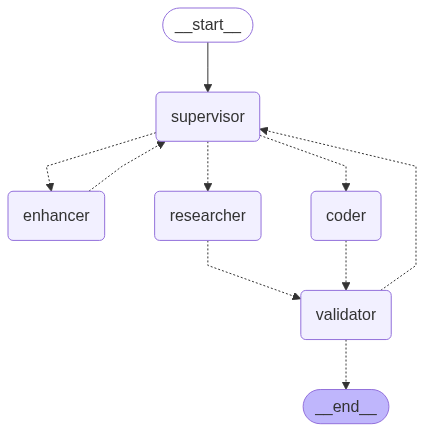

In [58]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [59]:
import pprint

inputs = {
    "messages": [
        ("user", "Weather in Greece, Athens today?"),
    ]
}

## server side rendering 
for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from the node: '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()

--- Workflow Transition: Supervisor -> RESEARCHER ---
"Output from the node: 'supervisor':"
HumanMessage(content='The user is asking for current weather information, which requires accessing up-to-date data. The Researcher is best equipped to gather the latest weather details for Athens, Greece.', additional_kwargs={}, response_metadata={}, name='supervisor', id='14169202-68dd-45fc-bb82-6cde4a8414cb')

--- Workflow Transition: Researcher -> Validator ---
"Output from the node: 'researcher':"
HumanMessage(content='The current weather in Athens, Greece is as follows:\n\n- **Temperature**: 25.2°C (77.4°F)\n- **Condition**: Sunny\n- **Wind Speed**: 11.9 mph (19.1 kph) from the West\n- **Humidity**: 32%\n- **Pressure**: 1010 mb\n- **Visibility**: 10 km\n- **UV Index**: 8\n- **Precipitation**: 0.0 mm\n\nThis information was last updated at 12:00 local time. [Source](https://www.weatherapi.com/)', additional_kwargs={}, response_metadata={}, name='researcher', id='c530398b-9840-4f3a-b896-96649

In [60]:
import pprint

inputs = {
    "messages": [
        ("user", "Give me the 20th fibonacci number."),
    ]
}

## server side rendering 
for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from the node: '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()

--- Workflow Transition: Supervisor -> CODER ---
"Output from the node: 'supervisor':"
HumanMessage(content="The user's request is clear and specific: they want the 20th Fibonacci number. This is a straightforward computational task that requires implementing an algorithm to calculate Fibonacci numbers, which falls under the Coder's expertise.", additional_kwargs={}, response_metadata={}, name='supervisor', id='b9ee6170-af5c-45d6-ae7d-1c4623f13f53')

--- Workflow Transition: Coder -> Validator ---
"Output from the node: 'coder':"
HumanMessage(content='The 20th Fibonacci number is 6765.', additional_kwargs={}, response_metadata={}, name='coder', id='fef4b554-82a1-4b5b-af60-272473779119')

--- Transitiong to end the workflow ---
"Output from the node: 'validator':"
HumanMessage(content="The answer correctly provides the 20th Fibonacci number, addressing the user's question.", additional_kwargs={}, response_metadata={}, name='validator', id='fb04d7b0-2929-47fa-8641-a7e532151a6d')

